# CS4243 Project

Deep learning in computer vision is typically targeted at tasks that humans excel in, but computers find much harder to process. Nowadays, with the advent of numerous deep learning architectures like VGG19, object recognition and segmentation tasks are well within the realms of reasonable accuracy for computers. In this project, we target a task that even humans might struggle with - the classification of paintings. While a layperson might be able to distinguish the brushy, impressionist style of Auguste Renoir from the distinctive abstract expressionist style of Jackson Pollock, a strong background in art is often necessary for the more nuanced painting classifications.

The objective of this project is to train a deep learning model to classify paintings according to various attributes (artist, genre, style) and investigate what features allow certain paintings to be grouped together distinctly from others. 



---



*Note: Due to limitations in training and testing, this report will be focused on the artist attribute over the other attributes where necessary. We also limit ourselves to four classes in each category for ease of training.*

The data and other files referred to in this notebook can be found [here](https://drive.google.com/drive/folders/1HswCm4dw4AOHlGv0fkceXiMx_TwTlBJk?usp=sharing). This notebook was created using a variety of platforms including Google Colab, Kaggle, and the author's personal computer. While care has been taken to ensure cross-compatability between platforms, sections of code might need slight modifications to be suitable for a specific environment.

## Data Acquisition

### Selecting the artists

The first step of data acquisition is to select the artists we wish to investigate. Artists with a large amount of published work would be preferred so as to increase the amount of training data available to our model. We also wish to select painters who are well-known. 

For this data, we use `BeautifulSoup` and `Selenium` to scrape a page on [WikiART](https://www.wikiart.org/en/popular-artists) - an online visual art encyclopedia - that lists 240 of its most popular artists by most visited.

The code for scraping the webpage:

*Note: It requires an appropriate version of chromedriver to be installed.*

In [ ]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from operator import itemgetter
import time
import csv

URL = "https://www.wikiart.org/en/Popular-Artists/" 
SLEEP_TIME = 3
NUM_OF_ARTISTS = 4

options = Options()
options.add_experimental_option('excludeSwitches', ['enable-logging'])

# change this path as necessary
# correct version of chromedriver must be installed
service = Service("C:\chromedriver_win32\chromedriver.exe")

driver = webdriver.Chrome(service=service, options=options)
driver.get(URL) 

# load time
time.sleep(SLEEP_TIME) 

# close pop-up if it exists
try:
    driver.find_element(By.XPATH, "//button[contains(@class, 'needsclick')]").click()
    time.sleep(SLEEP_TIME) 
except:
    pass

# scroll to bottom
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

load_button = driver.find_element(By.XPATH, "//a[contains(.,'LOAD MORE')]")

for _ in range(SLEEP_TIME):
    load_button.click()
    time.sleep(SLEEP_TIME) 

    # scroll to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SLEEP_TIME) 

    try:
        driver.find_element(By.XPATH, "//button[contains(@class, 'needsclick')]").click()
    except:
        pass

soup = BeautifulSoup(driver.page_source, "html.parser")
data = soup.find("ul", class_="wiki-artistgallery-container")

# parse artist names and work count
artist_names = []
work_count = []
for li in data.find_all("li"):
    artist_name = li.find("div", class_="artist-name").find("a")
    artist_names.append(artist_name.text.strip())
    num_of_works = li.find("div", class_="works-count")
    try:
        work_count.append(int(num_of_works.text.strip().split()[0]))
    except:
        pass

driver.quit()

# find top artists
top_artists = []
for artist, num_of_works in zip(artist_names, work_count):
    if len(top_artists) < NUM_OF_ARTISTS:
        top_artists.append([artist, num_of_works])
        top_artists = sorted(top_artists, key=itemgetter(1))
    elif num_of_works > top_artists[0][1]:
        top_artists.pop(0) 
        top_artists.append([artist, num_of_works])
        top_artists = sorted(top_artists, key=itemgetter(1))

print(top_artists)

# export to csv
with open("most_popular_classical_artists.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(top_artists)

At the time of writing, the four popular artists with the most number of works are
1. Vincent van Gogh, 1931 works
2. Nicholas Roerich, 1843 works
3. Pierre-Auguste Renoir, 1412 works
4. Claude Monet, 1366 works

### Obtaining information about artworks by the artists

The next step is to obtain the list of works by each artist. We do this by querying the [WikiART JSON API](https://www.wikiart.org/en/App/GetApi). 

In [ ]:
import pandas as pd
import requests
import json
import os

path = globals()['_dh'][0] + "/"
df = pd.read_csv(path + '\most_popular_classical_artists.csv', sep=',', names=["artist_names", "num_of_works"])
print(df)
artists = df["artist_names"].str.lower()
artists = artists.replace(' ', '-', regex=True)
json_urls = artists.map('https://www.wikiart.org/en/App/Painting/PaintingsByArtist?artistUrl={}&json=2'.format)

for url, artist in zip(json_urls, artists):
    page = requests.get(url)
    artworks = json.loads(page.text)
    df = pd.DataFrame(artworks)
    df.to_csv(path + '\dataframe_of_artworks\\' + artist + '.csv', index=False)

### Downloading images of artworks

A `csv` file of the list of artworks and their relevant information in JSON format are thus obtained for each artist. The files contain links to view the respective artworks as well, which we utilize to download `png` images of the artworks as follows.

In [ ]:
from pathlib import Path
import pandas as pd
import requests
import os

path = globals()['_dh'][0] + "/"
dir_path = path + '\dataframe_of_artworks\\'
files = os.listdir(dir_path)

filepath = Path(path).parent.parent.absolute()
filepath = str(filepath) + '\\data\\classical_art\\'

for file in files:
    # precautionary measure
    if not os.path.isfile(os.path.join(dir_path, file)):
        continue

    df = pd.read_csv(dir_path + file, sep=',')
    image_urls = df["image"]
    filenames = df["contentId"].map("{}.jpg".format)

    # adapted from https://stackoverflow.com/questions/30229231/python-save-image-from-url#answer-30229298 by DeepSpace
    for url, filename in zip(image_urls, filenames):
        # skip if file already exists
        if os.path.isfile(os.path.join(filepath, filename)):
            continue

        response = requests.get(url, stream = True)

        if not response.ok:
            print("Image with content id", filename, "could not be downloaded successfully.")
            continue

        with open(filepath + filename, 'wb') as f:
            for block in response.iter_content(1024):
                if not block:
                    break

                f.write(block)

## Data Exploration

Run the following code to be able to view the diagrams later in this notebook.

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_Project/'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

current_folder = globals()['_dh'][0] + "/"
try:
  current_folder = path_to_file
except:
  pass

### Spread of data across classes

We first look at the number of artworks across classes. 

In [ ]:
import pandas as pd
import plotly.express as px
import os

path = current_folder
df = pd.read_csv(path + 'downloaded_data.csv', sep=',')

# num of artworks per artists
num_of_artwork_artists = df['artistName'].value_counts()
label = ["Vincent van Gogh", "Pierre-Auguste Renoir", "Monet Claude", "Roerich Nicholas"]

num_of_artwork_artists.plot.pie(figsize=(10, 10), autopct='%1.1f%%', labels=label, label="")
print(num_of_artwork_artists)

Observe that the dataset is slightly unbalanced with respect to artists at the moment.

Notice that there are some rows with multiple entries for genre and style. Here, `value_counts` does not help much - we calculate the frequency of words instead.

In [ ]:
# num of artworks per genre
num_of_artwork_genre = df['genre'].str.get_dummies(sep=', ').sum()
df_genre_count = pd.DataFrame({'genre':num_of_artwork_genre.index, 'count':num_of_artwork_genre.values})
df_genre_count = df_genre_count.sort_values(by=['count'])

plt = df_genre_count.plot.pie(y='count', figsize=(10, 10), autopct='%1.1f%%', labels=df_genre_count['genre'], label="")
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0)
print(df_genre_count)

There are many genres with negligible number of artwork. `Poster`, for instance, has a singular associated artwork. Oversampling them would thus be unnecessary; they can later be removed from the artwork without significant loss on the model.

In [ ]:
# num of artworks per style
num_of_artwork_style = df['style'].str.get_dummies(sep=', ').sum()
df_style_count = pd.DataFrame({'style':num_of_artwork_style.index, 'count':num_of_artwork_style.values})
df_style_count = df_style_count.sort_values(by=['count'])

plt = df_style_count.plot.pie(y='count', figsize=(10, 10), autopct='%1.1f%%', labels=df_style_count['style'], label="")
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0)
print(df_style_count)

As with genre, there are many styles with negligible number of artwork as well. `Academicism`, for instance, has a singular associated artwork. Oversampling these would be unnecessary; they can later be removed from the artwork without significant loss on the model.

### Relationships between attributes

We next take a look at whether there are correlations between different attributes.

Plotting a scatter plot for the dimensions of an artwork against their artist shows a correlation between small dimensions and Roerich Nicholas. That is, if a given artwork is large, it is likely to not be attributable to Roerich Nicholas. 

This holds important implications for the data pre-processing stage that will be discussed later.

In [ ]:
# width, height vs artist 
widthHeightArtistPlot = px.scatter(df, x="width", y="height", color="artistName", color_discrete_map={
                "van Gogh Vincent": "red",
                "Renoir Pierre-Auguste": "green",
                "Monet Claude": "blue",
                "Roerich Nicholas": "gray"}, custom_data=['genre', 'style', 'title', 'completitionYear'],
                labels={
                "artistName": "Artist",  "width": "Width of painting", "height": "Height of painting"
            })

widthHeightArtistPlot.update_traces(
    hovertemplate="<br>".join([
        "Title: %{customdata[2]}",
        "Genre: %{customdata[0]}",
        "Style: %{customdata[1]}",
        "Width: %{x}",
        "Height: %{y}",
        "Completion year: %{customdata[3]}"
    ])
)

widthHeightArtistPlot.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)


widthHeightArtistPlot.show()

Plotting a scatter plot for the dimensions of an artwork against the year of completion, on the other hand, shows a clear correlation between later years and a slow progression towards smaller dimensions. This might be in part due to the ongoing WW2 efforts in the early 1940s.

*Note: The year of completion of an artwork is not covered in this project, but there is potential for future work on this.*

In [ ]:
# width, height vs completionYear
widthHeightYearPlot = px.scatter(df, x="width", y="height", color="completitionYear", \
        custom_data=['genre', 'style', 'title', 'artistName'], \
        labels={"completitionYear": "Completion year",  "width": "Width of painting", "height": "Height of painting"})

widthHeightYearPlot.update_traces(
    hovertemplate="<br>".join([
        "Title: %{customdata[2]}",
        "Artist name: %{customdata[3]}",
        "Genre: %{customdata[0]}",
        "Style: %{customdata[1]}",
        "Width: %{x}",
        "Height: %{y}",
    ])
)

widthHeightYearPlot.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)


widthHeightYearPlot.show()

## Data Pre-Processing

### Handling data points with multiple entries in genre, style

As mentioned in the data exploration stage, there are a few data points with multiple entries for genre and style in the pandas dataframe and handling this appropriately is essential before moving onto additional pre-processing steps.

There are three main approaches:
1. Select one of the entries for each row
2. Add duplicate rows, with each row having a singular valid entry in the respective column
3. Remove rows from dataset

**Approach 1**

Selecting one entry for each such data point, in essence, means rejecting the other entry for that data point. This might contribute to building up inaccuracies in the model.

**Approach 2**

This is likely to yield a more accurate model than approach 1, since each entry is represented once, and there is more data. However, this might make testing more complicated, for a singular image can have only one predicted output label for a given attribute in typical architectures. 

**Approach 3**

These entries do not make up a substantial part of the dataset, and thus can be safely discarded. This was the chosen approach. The code for this is given below.


In [ ]:
import pandas as pd
import plotly.express as px
import os

path = current_folder
df = pd.read_csv(path + 'downloaded_data.csv', sep=',')

df = df[~df['genre'].str.contains(",")]
num_of_artwork_genre = df['genre'].value_counts()

df = df[~df['style'].str.contains(",")]
num_of_artwork_style = df['style'].value_counts()

### Filtering the top four genre, style

The next step is to filter by genre and style, thereby removing small classes from the dataset. We do this by sorting the top four genre and style with most artworks as follows.

In [ ]:
# select top 4 genre and style
selected_genre = num_of_artwork_genre.index[:4].tolist()
selected_style = num_of_artwork_style.index[:4].tolist()
print(selected_genre)
print(selected_style)

df = df[df['genre'].isin(selected_genre)]
df = df[df['style'].isin(selected_style)]

df.to_csv(path + '\\cleaned_downloaded_data.csv', index=False)

We then analyze the remaining data.

In [ ]:
# num of artworks per artists
num_of_artwork_artists = df['artistName'].value_counts()
label = ["Vincent van Gogh", "Pierre-Auguste Renoir", "Monet Claude", "Roerich Nicholas"]
plt2 = num_of_artwork_artists.plot.pie(figsize=(10, 10), autopct='%1.1f%%', labels=label, label="")
print(num_of_artwork_artists)

In [ ]:
# num of artworks per genre
num_of_artwork_genre = df['genre'].value_counts()
plt3 = num_of_artwork_genre.plot.pie(figsize=(10, 10), autopct='%1.1f%%', label="")
print(num_of_artwork_genre)

In [ ]:
# num of artworks per style
num_of_artwork_style = df['style'].value_counts()
pl4 = num_of_artwork_style.plot.pie(figsize=(10, 10), autopct='%1.1f%%', label="")
print(num_of_artwork_style)

In [ ]:
grouped_df = df[["genre", "style", "artistName"]]
grouped_df = grouped_df.groupby(grouped_df.columns.tolist(),as_index=False).size()

fig = px.scatter(grouped_df, x="genre", y="style", size="size", color="artistName", \
                 hover_name="artistName", size_max=60, \
                 labels = {"genre":"Genre", "style":"Style", "size":"Num of works", "artistName":"Artist"}, \
                 custom_data=["size", "artistName"])

fig.update_traces(
    hovertemplate="<br>".join([
        "Genre: %{x}",
        "Style: %{y}",
        "Num of works: %{customdata[0]}",
        "Artist: %{customdata[1]}"
    ])
)

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)

fig.show()
fig.write_html(current_folder + "augmented_data.html")

At this point, the data is rather unbalanced for style, genre and artist attributes as can be seen from the bubble chart, as well as from the pie charts. A crucial point of observation is that certain artists have strong correlation with certain styles. Roerich Nicholas's works, for instance, appears to lean mostly into symbolism, whereas Vincent van Gogh has many artworks under post-impressionism and realism, but little to none for impressionism and symbolism. 

This is expected - Vincent van Gogh, for example, is considered to be one of the most influential post-impressionist painters. 

### Add padding 

The next step in pre-processing is to ensure that all images are of the same size. There are multiple ways to achieve this. One can transform larger images to become smaller ones by means of cropping, stretching, etc. Smaller images can also be transformed to become larger images by means of stretching, padding etc. 

As observed in the earlier data exploration stage, the dimensions (width and height) of an artwork might provide meaningful information to a model about an artwork being the handiwork of certain artists. As such, maintaining this feature is essential in this step of post-processing. Any sort of affine transformation or stretching does not preserve the relative sizes of any two given images. In addition, affine transformations might distort artistic traits of paintings as well.

Therefore, padding is chosen to resize images to a uniform size. All images are padded to the largest dimensions any image in the dataset has - in this case, 600 (H) x 750 (W). The code for that is as follows.

*Warning: Do not run the following cell unless you wish to overwrite data*

In [ ]:
import pandas as pd
import os
import cv2
import math

path = globals()['_dh'][0] + "/"
df = pd.read_csv(path + '\cleaned_downloaded_data.csv', sep=',')

image_path = str(path) + "\\data\\classical_art\\"
image_names = df["contentId"].map("{}.jpg".format)

max_width = 0
max_height = 0
for image_name in image_names:
    # if file does not exist
    filepath = os.path.join(image_path, image_name)
    if not os.path.isfile(filepath):
        print("Cannot find image file with content id ", image_name)
        continue

    img=cv2.imread(filepath)
    height, width = img.shape[0:2]
    if width > max_width:
        max_width = width
    if height > max_height:
        max_height = height

print(max_height, max_width)

# add padding
for image_name in image_names:
    # if file does not exist
    filepath = os.path.join(image_path, image_name)
    if not os.path.isfile(filepath):
        print("Cannot find image file with content id ", image_name)
        continue
    
    img = cv2.imread(filepath)
    height, width = img.shape[0:2]

    top_padding = math.floor((max_height - height) / 2)
    bottom_padding = max_height - height - top_padding
    left_padding = math.floor((max_width - width) / 2)
    right_padding = max_width - width - left_padding
    image = cv2.copyMakeBorder(img, top_padding, bottom_padding, left_padding, right_padding, \
        cv2.BORDER_CONSTANT, value=(255, 255, 255))

    new_name = "_" + image_name
    new_filepath = os.path.join(str(path) + "\\data\\padded_images\\", new_name)
    cv2.imwrite(new_filepath, image)


### Augment data

The focus of this project will be on classifing the artist of artworks. Given the difficult task of normalising data across three different attributes, each with four different classes, the goal of this step will be to normalize data with respect to the artist classes. Each artist will have ~30k images. For this, van Gogh's artworks have to be augmented once, Renoir's artwork twice, Monet three times, and Roerich seven times.

In line with minimizing distortions on the artwork, only transformations that preserve the local artwork structure will be used. In addition, to ensure the heterogenity of images, the transformations applied will be random. In this case, they are 
- RandomHorizontalFlip
- RandomResizedCrop
- RandomVerticalFlip.

The code for this is as follows.

*Note: Do not run the following cell unless you wish to overwrite data*

In [ ]:
import torchvision
from torchvision import transforms
import pandas as pd
from PIL import Image
import os

path = globals()['_dh'][0] + "/"
df = pd.read_csv(path + '\cleaned_downloaded_data.csv', sep=',')

# roughly normalize dataset 
artists = df["artistName"].unique()
#print(dict)
#['van Gogh Vincent ' 'Monet Claude' 'Renoir Pierre-Auguste' 'Roerich Nicholas']
counts = [1, 3, 2, 7]
artist_multiplier = dict(zip(artists, counts))

image_path = str(path) + "\\data\\padded_images\\"
image_names = df["contentId"].map("_{}.jpg".format)

max_height = 600
max_width = 750
aspect_ratio = max_height / max_width

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((max_height, max_width), scale=(0, 1), ratio=(aspect_ratio,aspect_ratio))
])

for image_name, artist in zip(image_names, df["artistName"]):
    # if file does not exist
    filepath = os.path.join(image_path, image_name)
    if not os.path.isfile(filepath):
        print("Cannot find image file with content id ", image_name)
        continue
    
    img = Image.open(filepath)

    for j in range(artist_multiplier[artist]):
        # apply transformation, save as new image
        image = T(img)

        new_name = "_" + str(j) + image_name
        new_filepath = os.path.join(str(path) + "\\data\\padded_images\\", new_name)
        torchvision.utils.save_image(image, new_filepath)

df_updated = df.copy(deep=True)
df_updated['contentId'] = '_' + df_updated['contentId'].astype(str) 
print(df_updated['contentId'].head())

for artist in artists:
    multiplier = artist_multiplier[artist]
    for i in range(multiplier):
        temp_df = df[df["artistName"] == artist]
        temp_df["contentId"] = "_" + str(i) + "_" + temp_df["contentId"].astype(str)
        df_updated = pd.concat([df_updated, temp_df])

df_updated.to_csv(path + '\\augmented_data.csv', index=False)

### Reduce size of images

The final step of data pre-processing is to reduce the size of the images. While a higher resolution generally tends to yield better results, the current dataset is a little over a gigabyte is size, and loading or otherwise manipulating data is a long process. 

The size of all images will be reduced from (600,750) to (120,150) using the [Python Imaging Library](https://pillow.readthedocs.io/en/stable/) as follows.

*Note: Do not attempt to run the following cell unless you wish to overwrite data*

In [ ]:
import pandas as pd
from PIL import Image
import os

path = os.path.dirname(os.path.realpath(__file__))
df = pd.read_csv(path + '\\augmented_data.csv', sep=',')

image_path = str(path) + "\\data\\padded_images\\"
image_names = df["contentId"].map("{}.jpg".format)

max_height = 600
max_width = 750
divisor = 5

for image_name in image_names:
    # if file does not exist
    filepath = os.path.join(image_path, image_name)
    if not os.path.isfile(filepath):
        print("Cannot find image file with content id ", image_name)
        continue
    
    img = Image.open(filepath)

    new_width  = int(max_width / divisor)
    new_height = int(max_height / divisor)
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    new_filepath = os.path.join(str(path) + "\\data\\smaller_images\\", image_name)
    img.save(new_filepath)

That completes the pre-processing of data.

## Data Analysis

We first implement a rudimentary multilayer perceptron (MLP) and a vanilla convolutional neural network (CNN) in a 1 vs REST process. Here, we build separate models for each attribute. 

### Set-up

In [2]:
import torch
print(torch.__version__)

print('cuda available with GPU:',torch.cuda.get_device_name(0))
!nvcc --version


In [3]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_Project/'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [4]:
# GPU Setup
if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('cuda not available')
    device = torch.device('cpu')

In [5]:
from sklearn.model_selection import train_test_split
from IPython.display import display
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

from random import randint
from PIL import Image
import time

### Load the data

In [6]:
current_folder = globals()['_dh'][0] + "/"
try:
  current_folder = path_to_file
except:
  pass

# if environment is Kaggle
# change directory path as necessary 
#current_folder = '../input/exploring-artworks/'

#images_location = os.path.join(current_folder,'data/smaller_images/')
df = pd.read_csv(current_folder + 'augmented_data.csv', sep=',')
print(df.head())

In [7]:
X = df["contentId"]
print(X.shape)

#### Size of an image

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()])

print(X[0])

size = None
image_path = str(current_folder) + "data/smaller_images/" + str(X[0]) + ".jpg"

if not os.path.isfile(image_path):
    print("Cannot find image file with content id ", X[0])
else:
    img = Image.open(image_path)
    display(img)
    image = transform(img)
    size = image.shape

print(size) 
# Notice torch.Size() = C, H, W
print(X.shape)

### Save all images as tensor

We load each image into a tensor and concatenate all images along a new dimension to obtain a new tensor of all image data.In particular, we seek to avoid the notion of `increasing_list = torch.cat(increasing_list, new_list)` for large lists as this is of quadratic complexity.  

We thus progressively stack every 400 consecutive tensors together (empirically determined to be a good cut-off before `torch.cat` operations become significantly slower), before merging the resulting stacks to form a larger tensor later on. 

*Note: You do not have to run the following cells. The data has been saved into a `.pt` file for later reference*

In [ ]:
X_data_list = []
X_data = torch.empty((0,size[0], size[1], size[2]))

i = 0
for x in X:
    i += 1

    image_path = str(current_folder) + "data/smaller_images/" + str(x) + ".jpg"
    
    # if no file found
    if not os.path.isfile(image_path):
        print("Cannot find image file with content id ", x)
        break
        continue

    image = transform(Image.open(image_path))
    if len(X_data.shape) > 3:
      # if not first iteration
      X_data = torch.cat((X_data, image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))), 0)
    else:
      # if first iteration
      X_data = torch.stack((X_data, image))

    if i == 400:
        X_data_list.append(X_data)
        X_data = torch.empty((0,size[0], size[1], size[2]))
        i = 0

    print(i, X_data.shape)

X_data_list.append(X_data)
X_data = torch.empty(size)

In [ ]:
X_data = torch.empty((0,size[0], size[1], size[2]))

for data in X_data_list:
    if X_data.nelement() == 0:
        if len(data.shape) == 3:
            X_data = data.reshape((1, data.shape[0], data.shape[1], data.shape[2]))
        else:
            X_data = data
    elif len(data.shape) == 3:
        X_data = torch.cat([X_data, data.reshape((1, data.shape[0], data.shape[1], data.shape[2]))], dim=0)
    else:
        X_data = torch.cat([X_data, data], dim=0)
    
    print(X_data.shape)

In [ ]:
torch.save(X_data, 'images_data.pt')

## MLP

### Split into training and testing sets

The objective of this section is to train an MLP with respect to artist, genre and style. 

We first load the image data. 

In [8]:
X = torch.load(current_folder+'images_data.pt')
print(X[0])

Next, we split the data into training sets and testing sets for each attribute. For each attribute, we relabel the classes with numbers. Note that each `X_train_attribute` is different.

We use a ratio of 9:1 for training data to testing data. 

#### Image vs Genre

In [14]:
y_genre = df["genre"]
print(y_genre.unique())
print(y_genre.head())

The labels used for genre are as follows:

| Genre | Label|
| :-- | :-: |
| sketch and study | 0 |
| portrait | 1 |
| genre painting | 2 |
| landscape | 3 |

In [15]:
labels_genre = {}

label = 0
for genre in y_genre.unique():
    labels_genre[genre] = label
    label += 1
    
for genre, label in labels_genre.items():
    y_genre = y_genre.replace({genre:label})

print(y_genre.unique())
print(y_genre.head())

In [16]:
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(X, y_genre, stratify=y_genre, test_size=0.10)

# convert to tensor
y_train_genre = torch.LongTensor(y_train_genre.values)
y_test_genre = torch.LongTensor(y_test_genre.values)

print(X_train_genre[0])
print(y_train_genre[0])
print(y_train_genre[:5])

#### Image vs Style

In [9]:
y_style = df["style"]
print(y_style.unique())
print(y_style.head())

The labels used for style are as follows:

| Style | Label|
| :-- | :-: |
| Post-Impressionism | 0 |
| Realism | 1 |
| Impressionism | 2 |
| Symbolism | 3 |

In [10]:
labels_style = {}

label = 0
for style in y_style.unique():
    labels_style[style] = label
    label += 1 
    
for style, label in labels_style.items():
    y_style = y_style.replace({style:label})

print(y_style.unique())
print(y_style.head())

In [11]:
X_train_style, X_test_style, y_train_style, y_test_style = train_test_split(X, y_style,stratify=y_style, test_size=0.10)

# convert to tensor
y_train_style = torch.LongTensor(y_train_style.values)
y_test_style = torch.LongTensor(y_test_style.values)

print(X_train_style[0])
print(y_train_style[0])
print(y_train_style[:5])

#### Image vs Artist

In [9]:
y_artist = df["artistName"]
print(y_artist.unique())
print(y_artist.head())

The labels used for artists are as follows:

| Style | Label|
| :-- | :-: |
| van Gogh Vincent | 0 |
| Monet Claude | 1 |
| Renoir Pierre-Auguste | 2 |
| Roerich Nicholas | 3 |

In [10]:
labels_artist = {}

label = 0
for artist in y_artist.unique():
    labels_artist[artist] = label
    label += 1
    
for artist, label in labels_artist.items():
    y_artist = y_artist.replace({artist:label})

print(y_artist.unique())
print(y_artist.head())

In [11]:
X_train_artist, X_test_artist, y_train_artist, y_test_artist = train_test_split(X, y_artist,stratify=y_artist, test_size=0.10)

# convert to tensor
y_train_artist = torch.LongTensor(y_train_artist.values)
y_test_artist = torch.LongTensor(y_test_artist.values)

print(X_train_artist[0])
print(y_train_artist[0])
print(y_train_artist[:5])

### Make a three-layer net class

A deep network is likely required to for this predictive modeling problem, but we opt for a standard three-layer net class as a starting point.

In [ ]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=False  )        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

The input size of the net is determined by the size of the images. 

In [12]:
input_size = np.prod(size)
print(input_size)

We build the net with the following additional parameters for all attributes:
- hidden size 1 = 900
- hidden size 2 = 500
- output size = 4 (four classes for each attribute)

We do not wish to have an excess of nodes, lest the net has a tendency to overfit. These values were empirically determined to be a good trade-off between accuracy and training time.

In [ ]:
net_genre  = three_layer_net(input_size,900,500,4)
net_genre = net_genre.to(device)
print(net_genre)

In [ ]:
net_style  = three_layer_net(input_size,900,500,4)
net_style = net_style.to(device)

In [ ]:
net_artist  = three_layer_net(input_size,900,500,4)
net_artist = net_artist.to(device)

### Choose the criterion, optimizer, batch rate and learning rate

We choose cross entropy loss as our loss criterion.
Since our data is sparse, we choose an optimizer with a dynamic learning rate.

Since we have sparse data, we wish to change the learning rate over time. While this can be done manually, we use [AdaDelta](https://paperswithcode.com/method/adadelta) as our optimizer to achieve this instead. AdaDelta performs sufficiently well in comparison with other commonly used optimizers like the stochastic gradient descent algorithm for the purposes of this project.

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-28_at_4.18.37_PM.png)

We do not have to set a default learning rate either. 

AdaDelta is, however, computationally more expensive as the second order derivatives have to be calculated, which might be a more significant issue with larger datasets. 

We set our batch size to 64. Note that the batch size is a factor of 2 so as to [maximize GPUs processing](https://www.intel.com/content/www/us/en/developer/articles/technical/cifar-10-classification-using-optimization-for-tensorflow.html). 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_genre = torch.optim.Adadelta(net_genre.parameters())
optimizer_style = torch.optim.Adadelta(net_style.parameters())
optimizer_artist = torch.optim.Adadelta(net_artist.parameters())

bs = 64

### Train

#### Genre

In [ ]:
for iter in range(1,5000):
    
    # Set dL/dU, dL/dV, dL/dW to be filled with zeros
    optimizer_genre.zero_grad()
     
    # create a minibatch
    indices = torch.LongTensor(bs).random_(0, 11440)
    minibatch_data =  X_train_genre[indices]
    minibatch_label = y_train_genre[indices]

    minibatch_data = minibatch_data.to(device)
    minibatch_label = minibatch_label.to(device)
    
    #reshape the minibatch
    inputs = minibatch_data.view(bs, 3*120*150)
    
    # tell Pytorch to start tracking all operations that will be done on "inputs"
    inputs.requires_grad_()

    # forward the minibatch through the net  
    scores = net_genre(inputs) 
    
    # Compute the average of the losses of the data points in the minibatch
    loss = criterion(scores, minibatch_label) 
    
    # backward pass to compute dL/dU, dL/dV and dL/dW    
    loss.backward()
    
    # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
    optimizer_genre.step()

In [ ]:
torch.save(net_genre.state_dict(), os.path.join(current_folder,'net_genre_mlp.pth'))

# Then later:
#model = torch.load(filepath)

#### Style

In [ ]:
for iter in range(1,5000):
    
    # Set dL/dU, dL/dV, dL/dW to be filled with zeros
    optimizer_style.zero_grad()
     
    # create a minibatch
    indices = torch.LongTensor(bs).random_(0, 11440)
    minibatch_data =  X_train_style[indices]
    minibatch_label = y_train_style[indices]

    minibatch_data = minibatch_data.to(device)
    minibatch_label = minibatch_label.to(device)
    
    #reshape the minibatch
    inputs = minibatch_data.view(bs, 3*120*150)
    
    # tell Pytorch to start tracking all operations that will be done on "inputs"
    inputs.requires_grad_()

    # forward the minibatch through the net  
    scores = net_style(inputs) 
    
    # Compute the average of the losses of the data points in the minibatch
    loss = criterion(scores, minibatch_label) 
    
    # backward pass to compute dL/dU, dL/dV and dL/dW    
    loss.backward()
    
    # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
    optimizer_style.step()

In [ ]:
torch.save(net_style.state_dict(), os.path.join(current_folder,'net_style_mlp.pth'))

# Then later:
#model = torch.load(filepath)

#### Artist

In [ ]:
for iter in range(1,5000):
    
    # Set dL/dU, dL/dV, dL/dW to be filled with zeros
    optimizer_artist.zero_grad()
     
    # create a minibatch
    indices = torch.LongTensor(bs).random_(0, 11440)
    minibatch_data =  X_train_artist[indices]
    minibatch_label = y_train_artist[indices]

    minibatch_data = minibatch_data.to(device)
    minibatch_label = minibatch_label.to(device)
    
    #reshape the minibatch
    inputs = minibatch_data.view(bs, 3*120*150)
    
    # tell Pytorch to start tracking all operations that will be done on "inputs"
    inputs.requires_grad_()

    # forward the minibatch through the net  
    scores = net_artist(inputs) 
    
    # Compute the average of the losses of the data points in the minibatch
    loss = criterion(scores, minibatch_label) 
    
    # backward pass to compute dL/dU, dL/dV and dL/dW    
    loss.backward()
    
    # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
    optimizer_artist.step()

In [ ]:
torch.save(net_artist.state_dict(), os.path.join(current_folder,'net_artist_mlp.pth'))

# Then later:
#model = torch.load(filepath)

### Test model

#### Genre

Testing on a random image yields the correct class label prediction.

In [ ]:
# choose a picture at random
test_genre_size = len(X_test_genre)

idx = randint(0, test_genre_size)
im = X_test_genre[idx]

# diplay the picture
#utils.show(im)

# feed it to the net and display the confidence scores
scores =  net_genre(im.view(1,54000).to(device)) 
probs = torch.softmax(scores, dim=1)

print(scores)
print(probs)
print(y_test_genre[idx])

Testing the model on the test set yields at accuracy of 70.99%.

In [ ]:
accuracy = [0, 0]

for X_temp, y_temp in zip(X_test_genre, y_test_genre):
    scores =  net_genre(X_temp.view(1,54000).to(device)) 
    probs = torch.softmax(scores, dim=1)

    if torch.argmax(probs) == y_temp:
        accuracy[0] += 1
    else:
        accuracy[1] += 1

print("Accuracy is {:.2f}%".format(accuracy[0] / (accuracy[0] + accuracy[1]) * 100))

#### Style

Testing on a random image yields the correct class label prediction.

In [ ]:
# choose a picture at random
test_style_size = len(X_test_style)

idx = randint(0, test_style_size)
im = X_test_style[idx]

# diplay the picture
#utils.show(im)

# feed it to the net and display the confidence scores
scores =  net_style(im.view(1,54000).to(device)) 
probs = torch.softmax(scores, dim=1)

print(scores)
print(probs)
print(y_test_style[idx])

Testing the model on the test set yields at accuracy of 64.39%.

In [ ]:
accuracy = [0, 0]

for X_temp, y_temp in zip(X_test_style, y_test_style):
    scores =  net_style(X_temp.view(1,54000).to(device)) 
    probs = torch.softmax(scores, dim=1)

    if torch.argmax(probs) == y_temp:
        accuracy[0] += 1
    else:
        accuracy[1] += 1

print("Accuracy is {:.2f}%".format(accuracy[0] / (accuracy[0] + accuracy[1]) * 100))

#### Artist

Testing on a random image yields the correct class label prediction.

In [ ]:
net_artist = three_layer_net(input_size,900,500,4).to(device)#torch.load(os.path.join(current_folder,'net_artist_mlp.pth'))
#model = Model()
net_artist.load_state_dict(torch.load(os.path.join(current_folder,'net_artist_mlp.pth')))
net_artist.eval()

In [ ]:
# choose a picture at random
test_artist_size = len(X_test_artist)

idx = randint(0, test_artist_size)
im = X_test_artist[idx]

# diplay the picture
#utils.show(im)

# feed it to the net and display the confidence scores
scores =  net_artist(im.view(1,54000).to(device)) 
probs = torch.softmax(scores, dim=1)

print(scores)
print(probs)
print(y_test_artist[idx])

Testing the model on the test set yields at accuracy of 67.37%.

In [ ]:
accuracy = [0, 0]

for X_temp, y_temp in zip(X_test_artist, y_test_artist):
    scores =  net_artist(X_temp.view(1,54000).to(device)) 
    probs = torch.softmax(scores, dim=1)

    if torch.argmax(probs) == y_temp:
        accuracy[0] += 1
    else:
        accuracy[1] += 1

print("Accuracy is {:.2f}%".format(accuracy[0] / (accuracy[0] + accuracy[1]) * 100))



---



In all three instances, the model can be further tweaked (e.g. one more hidden layer, varying the number of neurons in each layer) to achieve better results, but we shall treat this as a baseline for the next few models.

## Vanilla CNN

We first define a general-purpose error function, as well as a function that evaluates the accuracy of the model on the test set that we will use to evaluate the progress of the models-in-training later.

In [13]:
# credit to https://github.com/xbresson/CS4243_2022/blob/main/codes/labs_lecture06/lab02_cifar_multilayer/cifar_multilayer_solution.ipynb by xbresson
def get_error(scores, labels):

    bs = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    
    return 1 - num_matches.float()/bs    

In [22]:
# credit to https://github.com/xbresson/CS4243_2022/blob/main/codes/labs_lecture06/lab02_cifar_multilayer/cifar_multilayer_solution.ipynb by xbresson
def eval_on_test_set(net, attribute, bs):

    # choose appropriate test data
    if attribute == 'genre':
        test_data = X_test_genre
        test_label = y_test_genre
    elif attribute == 'style':
        test_data = X_test_style
        test_label = y_test_style
    else:
        test_data = X_test_artist
        test_label = y_test_artist

    test_data = test_data.to(device)
    test_label = test_label.to(device)

    running_error=0
    num_batches=0

    test_set_size = len(test_label)

    for i in range(0, test_set_size, bs):

        minibatch_data  =  test_data[i:i+bs]
        minibatch_label =  test_label[i:i+bs]

        actual_size = min(minibatch_data.shape[0], bs)

        inputs = minibatch_data.view(actual_size, 3*120*150)

        scores = net(inputs) 

        error = get_error(scores, minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print("Error rate on test set: {:.2f}%".format(total_error*100))
    
    return total_error

We use the same training/testing data splits, as well as the same model structure for each attribute as in the earlier section on MLPs. 

We opt for the Adam optimizer in this instance. 

We do 50 passes through the training set for each attribute.

In [20]:
criterion = nn.CrossEntropyLoss()

bs = 64

### Train

#### Genre

It was empirically observed that a learning rate of 0.01 was prone to non-convergence; the error rate on the test set fluctuated at around ~50% and the loss per epoch remained fairly constant for 200 epoches, with all other parameters being the same.

A learning rate of 0.001 was thus chosen for predicting genre. 

In [ ]:
net_genre = three_layer_net(input_size,900,500,4)
net_genre = net_genre.to(device)
optimizer_genre = torch.optim.Adam(net_genre.parameters(), lr=0.001)

In [ ]:
start = time.time()

loss_per_epoch_genre = []
error_per_epoch_genre = []
test_error_per_epoch_genre = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_genre = len(y_train_genre)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_genre)
 
    for count in range(0, train_size_genre, bs):
    
        # set the gradients to zeros
        optimizer_genre.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_genre[indices]
        minibatch_label =  y_train_genre[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_genre(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_genre.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_genre.append(eval_on_test_set(net_genre, 'genre', bs))
    print(' ')

In [ ]:
torch.save(net_genre.state_dict(), os.path.join(current_folder,'net_genre_vanilla_cnn.pth'))

# Then later:
#model = torch.load(filepath)

In [ ]:
torch.save(torch.Tensor(loss_per_epoch_genre), os.path.join(current_folder,'loss_per_epoch_genre_vanilla_cnn.pt'))
torch.save(torch.Tensor(error_per_epoch_genre), os.path.join(current_folder,'error_per_epoch_genre_vanilla_cnn.pt'))
torch.save(torch.Tensor(test_error_per_epoch_genre), os.path.join(current_folder,'test_error_per_epoch_genre_vanilla_cnn.pt'))

#### Style

We repeat the process for the style and artist attributes. 

In [ ]:
net_style = three_layer_net(input_size,900,500,4)
net_style = net_style.to(device)
optimizer_style = torch.optim.Adam(net_style.parameters(), lr=0.001)

In [ ]:
start = time.time()

loss_per_epoch_style = []
error_per_epoch_style = []
test_error_per_epoch_style = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_style = len(y_train_style)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_style)
 
    for count in range(0, train_size_style, bs):
    
        # set the gradients to zeros
        optimizer_style.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_style[indices]
        minibatch_label =  y_train_style[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_style(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_style.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_style.append(eval_on_test_set(net_style, 'style', bs))
    print(' ')

In [ ]:
torch.save(net_style.state_dict(), os.path.join(current_folder,'net_style_vanilla_cnn.pth'))

# Then later:
#model = torch.load(filepath)

In [ ]:
torch.save(torch.Tensor(loss_per_epoch_style), os.path.join(current_folder,'loss_per_epoch_style_vanilla_cnn.pt'))
torch.save(torch.Tensor(error_per_epoch_style), os.path.join(current_folder,'error_per_epoch_style_vanilla_cnn.pt'))
torch.save(torch.Tensor(test_error_per_epoch_style), os.path.join(current_folder,'test_error_per_epoch_style_vanilla_cnn.pt'))

#### Artist

In [ ]:
net_artist = three_layer_net(input_size,900,500,4)
net_artist = net_artist.to(device)
optimizer_artist = torch.optim.Adam(net_artist.parameters(), lr=0.001)

In [ ]:
start = time.time()

loss_per_epoch_artist = []
error_per_epoch_artist = []
test_error_per_epoch_artist = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_artist = len(y_train_artist)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_artist)
 
    for count in range(0, train_size_artist, bs):
    
        # set the gradients to zeros
        optimizer_artist.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_artist[indices]
        minibatch_label =  y_train_artist[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_artist(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_artist.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_artist.append(eval_on_test_set(net_artist, 'artist', bs))
    print(' ')

In [ ]:
torch.save(net_artist.state_dict(), os.path.join(current_folder,'net_artist_vanilla_cnn.pth'))

# Then later:
#model = torch.load(filepath)

In [ ]:
torch.save(torch.Tensor(loss_per_epoch_artist), os.path.join(current_folder,'loss_per_epoch_artist_vanilla_cnn.pt'))
torch.save(torch.Tensor(error_per_epoch_artist), os.path.join(current_folder,'error_per_epoch_artist_vanilla_cnn.pt'))
torch.save(torch.Tensor(test_error_per_epoch_artist), os.path.join(current_folder,'test_error_per_epoch_artist_vanilla_cnn.pt'))

### Test model

#### Genre

In [ ]:
net_genre = three_layer_net(input_size,900,500,4).to(device)
#model = Model()
net_genre.load_state_dict(torch.load(os.path.join(current_folder,'net_genre_mlp.pth')))
net_genre.eval()

Testing on a random image yields the correct class label prediction.

In [ ]:
# choose a picture at random
test_genre_size = len(X_test_genre)

idx = randint(0, test_genre_size)
im = X_test_genre[idx]

# diplay the picture
#utils.show(im)

# feed it to the net and display the confidence scores
scores =  net_genre(im.view(1,54000).to(device)) 
probs = torch.softmax(scores, dim=1)

print(scores)
print(probs)
print(y_test_genre[idx])

Testing the model on the test set yields at accuracy of 71.04%.

In [ ]:
test_error = eval_on_test_set(net_genre, 'genre', bs)
print("Accuracy is {:.2f}%".format(100-test_error*100))

#### Style

In [ ]:
net_style = three_layer_net(input_size,900,500,4).to(device)
#model = Model()
net_style.load_state_dict(torch.load(os.path.join(current_folder,'net_style_mlp.pth')))
net_style.eval()

Testing on a random image yields an incorrect class label prediction - class 2 is predicted instead of 3. 

In [ ]:
# choose a picture at random
test_style_size = len(X_test_style)

idx = randint(0, test_style_size)
im = X_test_style[idx]

# diplay the picture
#utils.show(im)

# feed it to the net and display the confidence scores
scores =  net_style(im.view(1,54000).to(device)) 
probs = torch.softmax(scores, dim=1)

print(scores)
print(probs)
print(y_test_style[idx])

Testing the model on the test set yields at accuracy of 66.90%.

In [ ]:
test_error = eval_on_test_set(net_style, 'style', bs)
print("Accuracy is {:.2f}%".format(100-test_error*100))

#### Artist

Testing on a random image yields the correct class label prediction.

In [ ]:
# choose a picture at random
test_artist_size = len(X_test_artist)

idx = randint(0, test_artist_size)
im = X_test_artist[idx]

# diplay the picture
#utils.show(im)

# feed it to the net and display the confidence scores
scores =  net_artist(im.view(1,54000).to(device)) 
probs = torch.softmax(scores, dim=1)

print(scores)
print(probs)
print(y_test_artist[idx])

Testing the model on the test set yields at accuracy of 56.81%.

In [ ]:
test_error = eval_on_test_set(net_artist, 'artist', bs)
print("Accuracy is {:.2f}%".format(100-test_error*100))

## Analysis 

The tabulated accuracy scores of the models on the test sets are as follows.

| Model\ Label | Genre | Style | Artist |
| :-: | :-: | :-: | :-: |
| MLP | 70.99% | 64.39% | 67.37% |
| CNN | 71.04% | 66.90% | 56.81 |


Genre appears to be consistently easier to identify across the models, while style and artist appear to be harder to classify. This seems to follow intuition, for the chosen genre here - sketch and study, portrait, genre painting, landscape - are more easy to distinguish to the typical human eye as opposed to, for instance, post-impressionism and impressionism, as is in the case of style. 

Do note that while the testing data is used as validation data in this project, ideally, there would be a separate set of testing data for more accurate results.

The CNN models, while having about the same accuracy as the MLP models in this particular implementation, appeared to be more volatile when subjected to changes in parameters; changing the learning rate from 0.01 to 0.001 alone increased the accuracy of the CNN for genre from ~50% to over 70%. 

As such, it is likely that with more training data and fine-tuned parameters, they will outperform the MLP models. 

This is an expected outcome given the nature of both models. MLP utilizes vector input whereas CNN utilizes tensor input, resulting in CNN models having a better capability to understand spatial relations across rows and columns. Since spatial relations between pixels matter more for the identification of features in image classification, CNN is expected to perform better than MLP with the right parameters and more data. 

Plotting the change of loss and running error of epoches in the CNN models over time reveals overfitting. 

In [16]:
current_folder = globals()['_dh'][0] + "\\"
try:
  current_folder = path_to_file
except:
  pass

# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_Project/'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [8]:
import torch

In [20]:
error_per_epoch_genre = torch.load(os.path.join(current_folder,'error_per_epoch_genre_vanilla_cnn.pt'))
test_error_per_epoch_genre = torch.load(os.path.join(current_folder,'test_error_per_epoch_genre_vanilla_cnn.pt'))

In [21]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go


# normalize training and test data error
test_error_per_epoch_genre = torch.mul(test_error_per_epoch_genre, 100)

# create dataframe
df = pd.DataFrame(np.column_stack([error_per_epoch_genre, test_error_per_epoch_genre]), \
                  columns=['Error per epoch', 'Test error per epoch'])

# add index
df['index'] = df.index + 1 

fig = px.line(df, x='index', y=["Error per epoch","Test error per epoch"], \
              labels={'index':'Epoch', 'Error per epoch':'Error per epoch', "Test error per epoch":"Test error per epoch"}, title="Genre")

fig.show()

Note that the error rate for the test set is slowly starting to increase whereas that of the training set is still steadily decreasing by the 50th epoch. This pattern is observed well after the 50th epoch into the 200th epoch as well. 

Plotting similar graphs for style and artist show a similar - perhaps milder - pattern.

In [22]:
error_per_epoch_style = torch.load(os.path.join(current_folder,'error_per_epoch_style_vanilla_cnn.pt'))
test_error_per_epoch_style = torch.load(os.path.join(current_folder,'test_error_per_epoch_style_vanilla_cnn.pt'))

In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go


# normalize training and test data error
test_error_per_epoch_style = torch.mul(test_error_per_epoch_style, 100)

# create dataframe
df = pd.DataFrame(np.column_stack([error_per_epoch_style, test_error_per_epoch_style]), \
                  columns=['Error per epoch', 'Test error per epoch'])

# add index
df['index'] = df.index + 1 

fig = px.line(df, x='index', y=["Error per epoch","Test error per epoch"], \
              labels={'index':'Epoch', 'Error per epoch':'Error per epoch', "Test error per epoch":"Test error per epoch"}, title="Style")

fig.show()

In [24]:
error_per_epoch_artist = torch.load(os.path.join(current_folder,'error_per_epoch_artist_vanilla_cnn.pt'))
test_error_per_epoch_artist = torch.load(os.path.join(current_folder,'test_error_per_epoch_artist_vanilla_cnn.pt'))

In [25]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go


# normalize training and test data error
test_error_per_epoch_artist = torch.mul(test_error_per_epoch_artist, 100)

# create dataframe
df = pd.DataFrame(np.column_stack([error_per_epoch_artist, test_error_per_epoch_artist]), \
                  columns=['Error per epoch', 'Test error per epoch'])

# add index
df['index'] = df.index + 1 

fig = px.line(df, x='index', y=["Error per epoch","Test error per epoch"], \
              labels={'index':'Epoch', 'Error per epoch':'Error per epoch', "Test error per epoch":"Test error per epoch"}, title="Artist")

fig.show()

The huge discrepancy between the accuracy of the test set and the training set is an indicator of possible overfitting as well. 

### Possible improvements

#### Overfitting

Overfitting occurs as a result of the model being too closely aligned with the training set. An overfitted model fails to generalize well from the training data used to new data.

In the above models, we use early-stopping as a means of preventing the model from being too overfitted to the training data, but the models still show a large discrepency between their prediction error on the training set and on the testing set. 

To counter this, we can force the models to be artificially simpler by regularization.

1. Dropout
  
  ![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-23_at_6.19.24_PM.png)

  Dropout is a regularisation technique that randomly shuts off neurons in a layer. The probability of any given neuron being shut off in a dropout layer, *p*, can be specified by the user. 

  Dropout forces the model to adapt to the loss of certain neurons, such that the complexity of the resulting model is reduced, as shown in the image above. This prevents overfitting with an appropriately chosen *p*, but can oversimplify the model if *p* is too large. 

2. Batch normalization

  ![](https://images.deepai.org/glossary-terms/981e1ffea3814ae193c27461253faf63/batch_normalization.png)

  Deep learning methods, including CNNs, are sensitive to the values of initial random weights.
  
  The presence of drastically large weights (by relativity to other weights) in a model can have a cascading effect through the neural network during training, causing the network to be more sensitive to the features with larger values and the feature activation distribution to shift towards larger values. Note that ReLU does not help in such cases as well. While this is by design of a neural network, an drastically large weight might result in the loss of information from other weights in the same layer over time.

  Batch normalization refers to the process of normalizing data for each layer in a network.

  Batch normalization is typically applied before an activation layer if the activation layer is ReLU. This is a three step process:
  
  1. Normalize output of layer
  2. Multiply normalized output by a “standard deviation” parameter $γ$
  3. Add a “mean” parameter $β$ to the output of (2)
  
  $x \mapsto \big( \frac{x-m}{s}\big)γ + β$

  $γ$ and β are also optimized during the training process. This ensures that the weights within the network are more balanced. 

  Batch normalization can increase the speed of training as well. 

  Dropout with batch normalization often lead to worse results in performance when applied together due to [variance shift differences](https://arxiv.org/pdf/1801.05134.pdf). As such, these techniques will have to be applied to separate models if used. 


#### Correlations

Thus far, the approach used for predicting the genre, style and artist of an artwork is to train individual models for each attribute. However, there are clear correlations between certain classes among these labels, as seen in the data pre-processing stage. 

![](https://i.imgur.com/GYkjjy5.png)




To calculate possible correlations between the categorical data, we use the uncertainty coefficient, a measure of nominal association. 

For two discrete random variables $X$, $Y$, their Shannon entropies are given by $H(X) = -\sum_x P_{X}(x)logP_{X}(x)$ and $H(Y) = -\sum_y P_{Y}(y)logP_{Y}(y)$ respectively. 

The uncertainty coefficient is defined in the following manner:

$U(X|Y)=\frac{H(X)-H(X|Y)}{H(X)}$

The uncertainty coefficient is in the range [0,1], where 0 denotes no association and 1 denotes full association. We use this over Cramer's V as it is asymmetric and thus more reflective of real-world relationships; feature A might give a lot of information about feature B, but the vice versa is not necessarily true. For instance, knowing that an artwork is by Monet implies that its style is likely impressionism, but an artwork's style being impressionism does not imply that the artist is Monet with an equally high probability.

We make use of the [`dython`](https://github.com/shakedzy/dython/) package to visualize this.

In [ ]:
#!pip list -v | grep 

# ensure that the following packages are installed with !pip list -v | grep <name>
# you may have to restart the notebook to be able to use the package
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install scipy
#!pip install matplotlib
#!pip install sklearn
#!pip install scikit-plot

In [ ]:
!pip install dython

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_Project/'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

current_folder = globals()['_dh'][0] + "/"
try:
  current_folder = path_to_file
except:
  pass

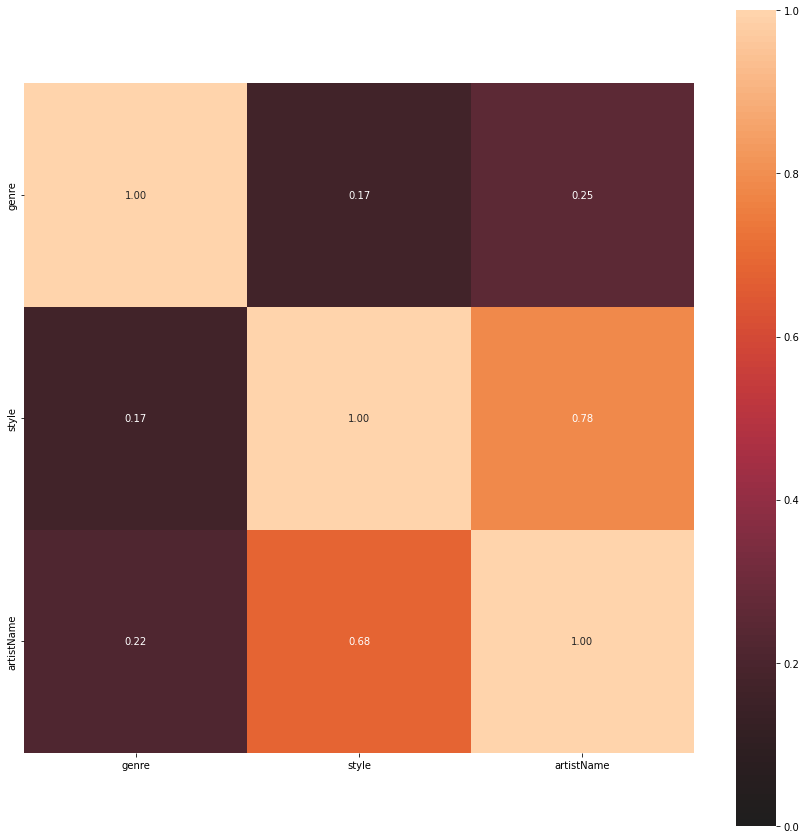

{'corr':                genre     style  artistName
 genre       1.000000  0.171027    0.252659
 style       0.167793  1.000000    0.781469
 artistName  0.216950  0.683955    1.000000,
 'ax': <AxesSubplot:>}

In [4]:
import pandas as pd
from dython.nominal import associations

# load data
df = pd.read_csv(current_folder + 'augmented_data.csv')

# delete irrelevant columns
columns_removed = ['title', 'contentId', 'artistContentId', 'completitionYear', 'width', 'height']
for column in columns_removed:
    df.drop(column, axis=1, inplace=True)

associations(df, nom_nom_assoc='theil', figsize=(15, 15))

From the diagram, we see that the artist and style attributes are fairly closely associated. This association appears to be mutual, even if knowing an artwork's style yields more information about an artist's name than vice versa.

An architecture that accounts for these correlations would likely yield better predictive performance than the current 1 v REST approach. 

## CNN with Dropout

The architecture of the network is updated from 

$L(54000,900) \rightarrow ReLU \rightarrow L(900,500) \rightarrow ReLU \rightarrow L(500,4) $

to 
$L(54000,900) \rightarrow ReLU  \rightarrow DO(0.5) \rightarrow L(900,500) \rightarrow ReLU \rightarrow L(500,4) $

where 
- `L` is a linear layer with the specified input and output features
- `ReLU` is the rectified linear activation function
- `DO` is Dropout with the specified probability of dropping a neuron

We keep all other parameters and data constant.

I.e. the optimizer is Adam, loss is given by the cross entropy loss, and training/testing sets are unchanged.

*Note: the results of previous cells in this notebook are required to run the following cells*

In [15]:
class DropoutCNN(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size, drop_prob=0.5):
        super(DropoutCNN , self).__init__()

        self.layer1  = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2  = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3  = nn.Linear(  hidden_size2 , output_size   , bias=False  ) 
        self.dropout = nn.Dropout(p=drop_prob)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        d       = self.dropout(y_hat)
        z       = self.layer2(d)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

In [21]:
def get_test_loss(net, attribute, bs, criterion):

    # choose appropriate test data
    if attribute == 'genre':
        test_data = X_test_genre
        test_label = y_test_genre
    elif attribute == 'style':
        test_data = X_test_style
        test_label = y_test_style
    else:
        test_data = X_test_artist
        test_label = y_test_artist

    test_data = test_data.to(device)
    test_label = test_label.to(device)

    running_loss=0
    num_batches=0

    test_set_size = len(test_label)

    net.eval()                                              
    with torch.no_grad():     
        for i in range(0, test_set_size, bs):

            minibatch_data  =  test_data[i:i+bs]
            minibatch_label =  test_label[i:i+bs]

            actual_size = min(minibatch_data.shape[0], bs)

            inputs = minibatch_data.view(actual_size, 3*120*150)

            scores = net(inputs) 

            loss = criterion(scores, minibatch_label)

            running_loss += loss.detach().item()

            num_batches+=1


    total_loss = running_loss/num_batches
    print("Loss on test set: {:.2f}%".format(total_loss))
    
    net.train()
    return total_loss   

### Genre

In [21]:
net_genre  = DropoutCNN(input_size,900,500,4)
net_genre = net_genre.to(device)
print(net_genre)

In [ ]:
optimizer_genre = torch.optim.Adam(net_genre.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bs = 64

In [ ]:
start = time.time()

loss_per_epoch_genre = []
error_per_epoch_genre = []
test_error_per_epoch_genre = []
test_loss_per_epoch_genre = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_genre = len(y_train_genre)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_genre)
 
    for count in range(0, train_size_genre, bs):
    
        # set the gradients to zeros
        optimizer_genre.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_genre[indices]
        minibatch_label =  y_train_genre[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_genre(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_genre.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_genre.append(eval_on_test_set(net_genre, 'genre', bs))
    test_loss_per_epoch_genre.append(get_test_loss(net_genre, 'genre', bs, criterion))
    print(' ')

In [ ]:
torch.save(net_genre.state_dict(), os.path.join(current_folder,'net_genre_dropoutcnn.pth'))

# Then later:
#model = torch.load(filepath)

In [ ]:
torch.save(torch.Tensor(loss_per_epoch_genre), os.path.join(current_folder,'loss_per_epoch_genre_dropout_cnn.pt'))
torch.save(torch.Tensor(error_per_epoch_genre), os.path.join(current_folder,'error_per_epoch_genre_dropout_cnn.pt'))
torch.save(torch.Tensor(test_error_per_epoch_genre), os.path.join(current_folder,'test_error_per_epoch_genre_dropout_cnn.pt'))

### Style

In [14]:
net_style = DropoutCNN(input_size,900,500,4)
net_style = net_style.to(device)
print(net_style)

In [17]:
optimizer_style = torch.optim.Adam(net_style.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bs = 64

In [18]:
start = time.time()

loss_per_epoch_style = []
error_per_epoch_style = []
test_error_per_epoch_style = []
test_loss_per_epoch_style = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_style = len(y_train_style)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_style)
 
    for count in range(0, train_size_style, bs):
    
        # set the gradients to zeros
        optimizer_style.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_style[indices]
        minibatch_label =  y_train_style[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_style(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_style.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_style.append(eval_on_test_set(net_style, 'style', bs))
    test_loss_per_epoch_style.append(get_test_loss(net_style, 'style', bs, criterion))
    print(' ')

In [22]:
# change path as necessary for your environment
torch.save(net_style.state_dict(), '/kaggle/working/net_style_dropoutcnn.pth')

# Then later:
#model = torch.load(filepath)

In [23]:
# change path as necessary for your environment

torch.save(torch.Tensor(loss_per_epoch_style), '/kaggle/working/loss_per_epoch_style_dropout_cnn.pt')
torch.save(torch.Tensor(error_per_epoch_style), '/kaggle/working/error_per_epoch_style_dropout_cnn.pt')
torch.save(torch.Tensor(test_error_per_epoch_style), '/kaggle/working/test_error_per_epoch_style_dropout_cnn.pt')

### Artist

In [17]:
net_artist  = DropoutCNN(input_size,900,500,4)
net_artist = net_artist.to(device)
print(net_artist)

In [18]:
optimizer_artist = torch.optim.Adam(net_artist.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bs = 64

In [21]:
start = time.time()

loss_per_epoch_artist = []
error_per_epoch_artist = []
test_error_per_epoch_artist = []
test_loss_per_epoch_artist = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_artist = len(y_train_artist)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_artist)
 
    for count in range(0, train_size_artist, bs):
    
        # set the gradients to zeros
        optimizer_artist.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_artist[indices]
        minibatch_label =  y_train_artist[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_artist(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_artist.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_artist.append(eval_on_test_set(net_artist, 'artist', bs))
    test_loss_per_epoch_artist.append(get_test_loss(net_artist, 'artist', bs, criterion))
    print(' ')

In [22]:
# change path as necessary for your environment
torch.save(net_artist.state_dict(), '/kaggle/working/net_artist_dropoutcnn.pth')

# Then later:
#model = torch.load(filepath)

In [23]:
# change path as necessary for your environment

torch.save(torch.Tensor(loss_per_epoch_artist), '/kaggle/working/loss_per_epoch_artist_dropout_cnn.pt')
torch.save(torch.Tensor(error_per_epoch_artist), '/kaggle/working/error_per_epoch_artist_dropout_cnn.pt')
torch.save(torch.Tensor(test_error_per_epoch_artist), '/kaggle/working/test_error_per_epoch_artist_dropout_cnn.pt')

## Batch normalization

The architecture of the network is updated from 

$L(54000,900) \rightarrow ReLU \rightarrow L(900,500) \rightarrow ReLU \rightarrow L(500,4) $

to 
$L(54000,900) \rightarrow ReLU  \rightarrow BatchNorm \rightarrow L(900,500) \rightarrow ReLU \rightarrow L(500,4) $

where 
- `L` is a linear layer with the specified input and output features
- `ReLU` is the rectified linear activation function
- `BatchNorm` is a layer of 1-dimensional batch normalization

We keep all other parameters and data constant.

I.e. the optimizer is Adam, loss is given by the cross entropy loss, and training/testing sets are unchanged.

*Note: the results of previous cells in this notebook are required to run the following cells*

In [15]:
class BatchNormCNN(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size, drop_prob=0.5):
        super(BatchNormCNN , self).__init__()

        self.layer1    = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.batchnorm = nn.BatchNorm1d(hidden_size1)
        self.layer2    = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3    = nn.Linear(  hidden_size2 , output_size   , bias=False  ) 
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        b       = self.batchnorm(y_hat)
        z       = self.layer2(b)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

### Genre

In [23]:
net_genre  = BatchNormCNN(input_size,900,500,4)
net_genre = net_genre.to(device)
print(net_genre)

In [24]:
optimizer_genre = torch.optim.Adam(net_genre.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bs = 64

In [27]:
start = time.time()

loss_per_epoch_genre = []
error_per_epoch_genre = []
test_error_per_epoch_genre = []
test_loss_per_epoch_genre = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_genre = len(y_train_genre)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_genre)
 
    for count in range(0, train_size_genre, bs):
    
        # set the gradients to zeros
        optimizer_genre.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_genre[indices]
        minibatch_label =  y_train_genre[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_genre(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_genre.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_genre.append(eval_on_test_set(net_genre, 'genre', bs))
    test_loss_per_epoch_genre.append(get_test_loss(net_genre, 'genre', bs, criterion))
    print(' ')

In [31]:
# modify path as necessary for your chosen environment
torch.save(net_genre.state_dict(), '/kaggle/working/net_genre_batchnormcnn.pth')

# Then later:
#model = torch.load(filepath)

In [32]:
# modify path as necessary for your chosen environment
torch.save(torch.Tensor(loss_per_epoch_genre), '/kaggle/working/loss_per_epoch_genre_batchnorm_cnn.pt')
torch.save(torch.Tensor(error_per_epoch_genre), '/kaggle/working/error_per_epoch_genre_batchnorm_cnn.pt')
torch.save(torch.Tensor(test_error_per_epoch_genre), '/kaggle/working/test_error_per_epoch_genre_batchnorm_cnn.pt')

### Style

In [17]:
net_style  = BatchNormCNN(input_size,900,500,4)
net_style = net_style.to(device)
print(net_style)

In [18]:
optimizer_style = torch.optim.Adam(net_style.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bs = 64

In [23]:
start = time.time()

loss_per_epoch_style = []
error_per_epoch_style = []
test_error_per_epoch_style = []
test_loss_per_epoch_style = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_style = len(y_train_style)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_style)
 
    for count in range(0, train_size_style, bs):
    
        # set the gradients to zeros
        optimizer_style.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_style[indices]
        minibatch_label =  y_train_style[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_style(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_style.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_style.append(eval_on_test_set(net_style, 'style', bs))
    test_loss_per_epoch_style.append(get_test_loss(net_style, 'style', bs, criterion))
    print(' ')

In [24]:
# modify path as necessary for your chosen environment
torch.save(net_style.state_dict(), '/kaggle/working/net_style_batchnormcnn.pth')

# Then later:
#model = torch.load(filepath)

In [25]:
# modify path as necessary for your chosen environment
torch.save(torch.Tensor(loss_per_epoch_style), '/kaggle/working/loss_per_epoch_style_batchnorm_cnn.pt')
torch.save(torch.Tensor(error_per_epoch_style), '/kaggle/working/error_per_epoch_style_batchnorm_cnn.pt')
torch.save(torch.Tensor(test_error_per_epoch_style), '/kaggle/working/test_error_per_epoch_style_batchnorm_cnn.pt')

### Artist

In [26]:
net_artist  = BatchNormCNN(input_size,900,500,4)
net_artist = net_artist.to(device)
print(net_artist)

In [27]:
optimizer_artist = torch.optim.Adam(net_artist.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bs = 64

In [28]:
start = time.time()

loss_per_epoch_artist = []
error_per_epoch_artist = []
test_error_per_epoch_artist = []
test_loss_per_epoch_artist = []

for epoch in range(50):
    
    running_loss=0
    running_error=0
    num_batches=0

    train_size_artist = len(y_train_artist)
    
    # obtain random indices
    shuffled_indices = torch.randperm(train_size_artist)
 
    for count in range(0, train_size_artist, bs):
    
        # set the gradients to zeros
        optimizer_artist.zero_grad()
        
        # create a minibatch       
        indices = shuffled_indices[count:count+bs]
        minibatch_data  =  X_train_artist[indices]
        minibatch_label =  y_train_artist[indices]
        
        # send them to the gpu
        minibatch_data  = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        actual_size = min(minibatch_data.shape[0], bs)
        
        # reshape the minibatch
        inputs = minibatch_data.view(actual_size, 3*120*150)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = net_artist(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores, minibatch_label) 
        
        # backward pass   
        loss.backward()

        # do one step of stochastic gradient descent
        optimizer_artist.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches += 1        
    
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    total_error = running_error / num_batches
    elapsed = time.time() - start

    loss_per_epoch_genre.append(total_loss)
    error_per_epoch_genre.append(total_error)
    
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    test_error_per_epoch_artist.append(eval_on_test_set(net_artist, 'artist', bs))
    test_loss_per_epoch_artist.append(get_test_loss(net_artist, 'artist', bs, criterion))
    print(' ')

In [29]:
# modify path as necessary for your chosen environment
torch.save(net_artist.state_dict(), '/kaggle/working/net_artist_batchnormcnn.pth')

# Then later:
#model = torch.load(filepath)

In [30]:
# modify path as necessary for your chosen environment
torch.save(torch.Tensor(loss_per_epoch_artist), '/kaggle/working/loss_per_epoch_artist_batchnorm_cnn.pt')
torch.save(torch.Tensor(error_per_epoch_artist), '/kaggle/working/error_per_epoch_artist_batchnorm_cnn.pt')
torch.save(torch.Tensor(test_error_per_epoch_artist), '/kaggle/working/test_error_per_epoch_artist_batchnorm_cnn.pt')

## Analysis: Dropout & Batch-Normalization

In the earlier sections, we applied dropout and batch regularization to vanilla CNN classifiers, with all other parameters being kept constant. In this section, we evaluate the performance of the resulting models.

The tabulated accuracy scores of the models on the test sets are as follows.

| Model\ Label | Genre | Style | Artist |
| :-: | :-: | :-: | :-: |
| MLP | 70.99% | 64.39% | 67.37% |
| Vanilla CNN | 71.04% | 66.90% | 56.81 |
| Dropout CNN | 49.30% | 52.18% | 39.42% |
| Batch-normalized CNN | 59.45% | 60.12% | 57.27% |

In [36]:
test_error_per_epoch_genre_dropout = torch.load(os.path.join(current_folder,'test_error_per_epoch_genre_dropout_cnn.pt'))
print(test_error_per_epoch_genre_dropout)

test_error_per_epoch_genre_batchnorm = torch.load(os.path.join(current_folder,'test_error_per_epoch_genre_batchnorm_cnn.pt'))
print(test_error_per_epoch_genre_batchnorm)


tensor([0.4624, 0.4776, 0.5397, 0.5520, 0.5468, 0.5273, 0.5182, 0.5218, 0.5204,
        0.4810, 0.4826, 0.5142, 0.5237, 0.5048, 0.4991, 0.5046, 0.5064, 0.5089,
        0.5015, 0.5127, 0.4934, 0.4944, 0.5041, 0.4869, 0.4980, 0.4917, 0.5059,
        0.4944, 0.5019, 0.4953, 0.5000, 0.4941, 0.5012, 0.4963, 0.5032, 0.5085,
        0.5046, 0.5039, 0.4921, 0.5089, 0.5021, 0.5145, 0.5132, 0.5092, 0.5031,
        0.5147, 0.5089, 0.5051, 0.4901, 0.5070])
tensor([0.3372, 0.3471, 0.3217, 0.3202, 0.3104, 0.3242, 0.3190, 0.3247, 0.3334,
        0.3114, 0.3368, 0.3288, 0.3288, 0.3123, 0.3470, 0.3381, 0.3396, 0.3334,
        0.3365, 0.3545, 0.3225, 0.3292, 0.3746, 0.3440, 0.3390, 0.3482, 0.3566,
        0.3469, 0.3469, 0.3560, 0.3602, 0.3603, 0.3577, 0.3557, 0.3690, 0.3571,
        0.3522, 0.3830, 0.3710, 0.3550, 0.3631, 0.3792, 0.3592, 0.3665, 0.3799,
        0.3830, 0.3710, 0.3599, 0.3596, 0.4055])


In [37]:
test_error_per_epoch_style_dropout = torch.load(os.path.join(current_folder,'test_error_per_epoch_style_dropout_cnn.pt'))
print(test_error_per_epoch_style_dropout)

test_error_per_epoch_style_batchnorm = torch.load(os.path.join(current_folder,'test_error_per_epoch_style_batchnorm_cnn.pt'))
print(test_error_per_epoch_style_batchnorm)


tensor([0.4638, 0.5513, 0.5108, 0.5032, 0.5291, 0.5340, 0.5195, 0.5040, 0.5297,
        0.5552, 0.5535, 0.5512, 0.5808, 0.5191, 0.4944, 0.5061, 0.5338, 0.4840,
        0.5315, 0.4831, 0.5166, 0.4820, 0.5059, 0.5113, 0.5127, 0.4949, 0.4953,
        0.4858, 0.5017, 0.5280, 0.5298, 0.5290, 0.4943, 0.5013, 0.5109, 0.4875,
        0.5286, 0.4975, 0.4913, 0.4850, 0.5098, 0.5244, 0.4670, 0.5093, 0.5025,
        0.4769, 0.4967, 0.4653, 0.4816, 0.4782])
tensor([0.3680, 0.3506, 0.3471, 0.3489, 0.3438, 0.3532, 0.3441, 0.3509, 0.3456,
        0.3479, 0.3554, 0.3599, 0.3517, 0.3395, 0.3778, 0.3440, 0.3477, 0.3856,
        0.3663, 0.3589, 0.3607, 0.3809, 0.3690, 0.3732, 0.3702, 0.3949, 0.3853,
        0.3836, 0.3747, 0.3758, 0.3895, 0.3895, 0.4065, 0.3990, 0.3958, 0.4123,
        0.3940, 0.4325, 0.3831, 0.3721, 0.4189, 0.3740, 0.3794, 0.3925, 0.3895,
        0.3830, 0.3857, 0.3857, 0.4131, 0.3988])


In [38]:
test_error_per_epoch_artist_dropout = torch.load(os.path.join(current_folder,'test_error_per_epoch_artist_dropout_cnn.pt'))
print(test_error_per_epoch_artist_dropout)

test_error_per_epoch_artist_batchnorm = torch.load(os.path.join(current_folder,'test_error_per_epoch_artist_batchnorm_cnn.pt'))
print(test_error_per_epoch_artist_batchnorm)

tensor([0.6238, 0.6459, 0.6057, 0.6374, 0.6275, 0.5833, 0.6173, 0.6086, 0.6211,
        0.6114, 0.5905, 0.6175, 0.6070, 0.5858, 0.6056, 0.6093, 0.6143, 0.6201,
        0.5806, 0.5860, 0.5661, 0.5882, 0.5792, 0.6113, 0.5689, 0.6443, 0.5730,
        0.5884, 0.5831, 0.5809, 0.5808, 0.5936, 0.5964, 0.5875, 0.5865, 0.5703,
        0.5907, 0.5814, 0.6100, 0.5719, 0.5877, 0.5799, 0.5834, 0.5965, 0.5843,
        0.5882, 0.5766, 0.5955, 0.5915, 0.6058])
tensor([0.4080, 0.4095, 0.4037, 0.3868, 0.3831, 0.4081, 0.3791, 0.3816, 0.3830,
        0.3710, 0.3981, 0.3804, 0.3711, 0.3819, 0.3722, 0.3823, 0.3673, 0.3977,
        0.3801, 0.4058, 0.4019, 0.4158, 0.3964, 0.3977, 0.4062, 0.4110, 0.4211,
        0.4243, 0.4044, 0.3931, 0.4235, 0.4209, 0.4196, 0.4431, 0.4219, 0.4270,
        0.4193, 0.4503, 0.3992, 0.4272, 0.4189, 0.4169, 0.4421, 0.4121, 0.4217,
        0.4291, 0.4368, 0.4508, 0.4189, 0.4273])


The dropout model was underfitted, and more data would likely help with the training of the model.

There are clear signs of overfitting on the dropout and batch-normalized models. For instance, at epoch 50, the batch-normalized artist classifier has a training error rate of 5.83% and a testing error rate of 42.73%. Similar patterns were observed for genre and style for both models. 

The batch-normalized model appeared to converge faster than the vanilla cnn, with overfitting occuring after the 16th epoch for the style and artist classifiers, and after the 4th epoch for the genre classifier. 

## Future Work

### Multilabel classification architecture

In this project, we utilized a one vs rest approach for multilabel classification of artworks using binary relevance. 

Future work can be done on training classifiers that account for this association, with a focus on style and artist name - as those were identified to be the two closely associated variables by the uncertainty coefficient metric in the earlier analysis. One possible way of achieving this is to construct a classifier chain. The prediction of a binary classifier for style can be used as input to train a secondary classifier for artist name. 


![](https://miro.medium.com/max/1400/1*ycwr_uE8_5lnOMNCnFOuXQ.png)
*Example of a classifier chain structure with three labels*

### Larger dataset, More classes for each label, More labels

The dataset used in this project was constructed to maximize the initial data available for training before augmentation. Future work can be on classifying artwork among similar genre, style or other labels. This might pose an issue with the amount of data available in typical data science tasks, and data augmentation will be a more significant step of such a project. 

Other labels such as the time period of an artwork's completion, and emotion detection can be explored as well, with the latter having possible applications to other fields such as robotics. 

Digital art is another avenue for exploration, and such a classifier would be useful in the detection of use of images without proper attribution to the artist on various platforms in the internet, with a possible application to non-fungible tokens on platforms like DeviantArt.


## Conclusion

In this project, we modelled the labelling of artwork with MLPs and CNNs, and investigated the effects of dropout and batch-normalization on the performance of a model. Batch-normalization converged faster than vanilla CNNs, but exhibited signs of overfitting, which early stopping can improve. Dropout led to a loss in performance, but prevented overfitting. Dropout coupled with a larger dataset to train on is a possible extension to this project, along with exploring the connotations of associations between categorical variables, as in the case of this problem. 